In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.tools.plotting import lag_plot
%matplotlib inline
%precision 4
from ipywidgets import widgets
from IPython.display import display
plt.style.use('ggplot')
import pystan
import util
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 50)
util.scale_plot_size(1.5)

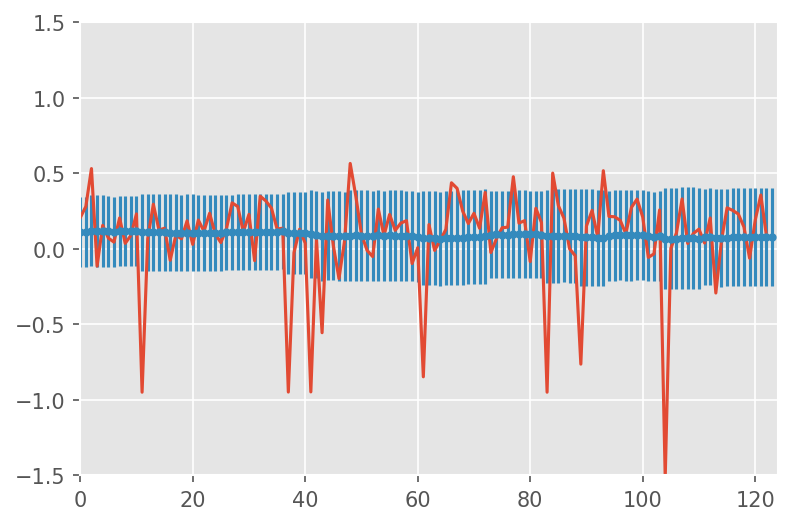

In [20]:
plot_series(['30925', '2016-5-4', '2016-6-30', 'Off the Tee'])

In [18]:
categories = ['Off the Tee', 'Approach to the Green', 'Around the Green', 'Putting']
def plot_series(params):
    sqlTxt = '''
    select strokes_gained_baseline 
      from strokes 
     where player_id = %s 
       and date > %s
       and date < %s
       and strokes_gained_category LIKE %s
       order by date, time;
    '''
    sg = util.pd_from_sql(sqlTxt, params)
    window = 100
    rolling = sg.rolling(window).mean().as_matrix()[window:]
    std_roll = sg.rolling(window).std().as_matrix()[window:]
    sg = sg[window:]
    plt.plot(range(0, len(sg)), sg)
    foo = plt.errorbar(range(0, len(rolling)), rolling, std_roll, linestyle=None, marker=".")
    plt.axis([0, len (sg), -1.5, 1.5])

0.8085 1.99846690583


array([ 0.596,  2.127,  3.093,  0.423, -1.508,  3.28 , -5.571,  2.623,
        1.335, -1.234, -0.364,  0.081, -1.076, -0.791,  1.715,  1.266,
        0.566, -1.333,  1.871,  2.429, -2.064, -0.336,  1.407,  2.787,
        2.743, -3.073,  1.335,  1.163,  2.982,  4.317,  2.913,  0.432,
       -3.238,  1.785,  2.766,  2.252,  1.024,  2.167, -0.334, -0.106,
        1.959, -0.784,  0.387,  2.816, -0.762, -1.897,  1.99 , -0.965,
        2.714,  1.237,  0.701,  3.814, -1.459,  1.021,  4.114,  0.038,
       -1.391,  2.91 ])

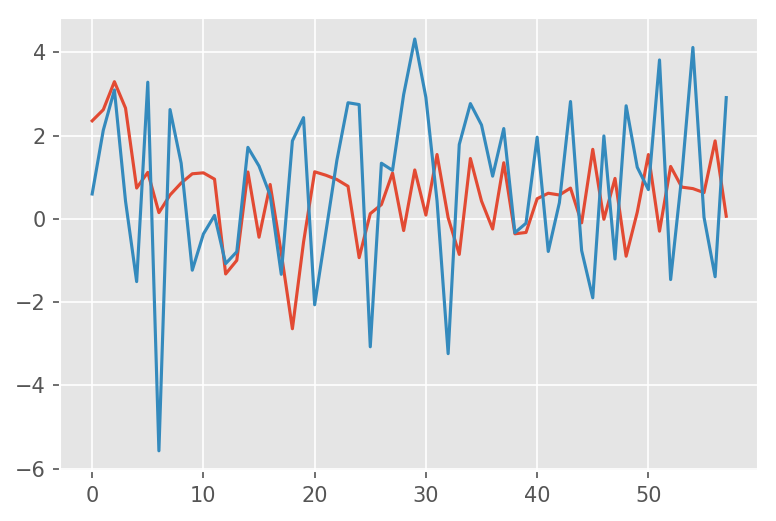

In [208]:
player = 'Jordan Spieth'
year = 2016
sqlTxt = '''
select * from scores, players 
    where year = %s 
      and name like %s 
      and scores.player_id = players.player_id
      and scores.sg_putting is not null
      order by date;
'''
df = util.pd_from_sql(sqlTxt, [year, player])
ts = df['sg_tee']
tsd = df['sg_putting']
plt.plot(range(0, len (ts)), ts)
plt.plot(range(0, len (tsd)), tsd)
import statsmodels.api as sm
import scipy.fftpack as fp
r = range(0, 20)
print tsd.mean(), tsd.std()
tsd.as_matrix()
# plt.plot(r, [ df['sg_tee'].autocorr(i) for i in r], label='tee')
# plt.plot(r, [ df['sg_approach'].autocorr(i) for i in r], label='approach')
# plt.plot(r, [ df['sg_around'].autocorr(i) for i in r], label='around')
# plt.plot(r, [ df['sg_putting'].autocorr(i) for i in r], label='putting')
# plt.legend(loc='upper right')

In [195]:

import statsmodels.api as sm
from statsmodels.tsa.arima_process import arma_generate_sample
# dates = sm.tsa.datetools.dates_from_range('1980m1', length=nobs)
# y = pd.Series(y, index=dates)
dates = sm.tsa.datetools.dates_from_range('2016m1', length=len(df))
y = tsd.as_matrix()
arma_mod = sm.tsa.ARMA(y, order=(1,0), dates = dates)
arma_res = arma_mod.fit(trend='nc', disp=-1)
print(arma_res.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   58
Model:                     ARMA(1, 0)   Log Likelihood                 -85.337
Method:                       css-mle   S.D. of innovations              1.052
Date:                Fri, 11 Aug 2017   AIC                            174.674
Time:                        19:42:35   BIC                            178.795
Sample:                    01-31-2016   HQIC                           176.279
                         - 10-31-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.4466      0.121      3.702      0.000       0.210       0.683
                                    Roots                                    
                 Real           Imaginary           M

array([ 0.8357,  0.0272,  0.0122])

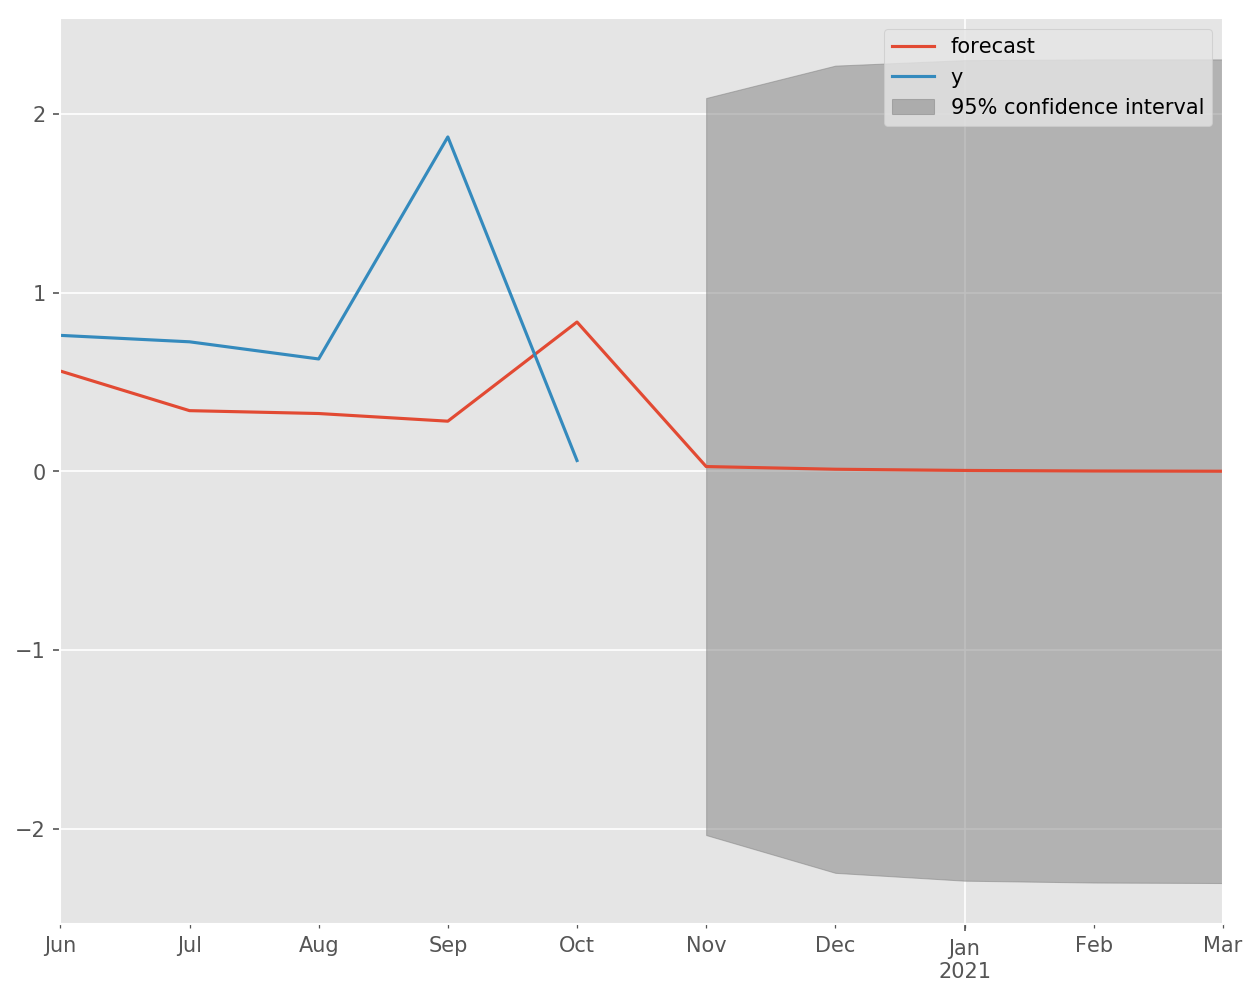

In [207]:
fig, ax = plt.subplots(figsize=(10,8))
fig = arma_res.plot_predict(start='2020-06-30', end='2021-03-31', ax=ax) 
legend = ax.legend(loc='upper right')
arma_res.predict(start='2020-10-31', end='2020-12-31') 

count    22.000000
mean      0.220409
std       0.327175
min      -0.562000
25%       0.081000
50%       0.167000
75%       0.422750
max       1.101000
Name: strokes_gained_baseline, dtype: float64

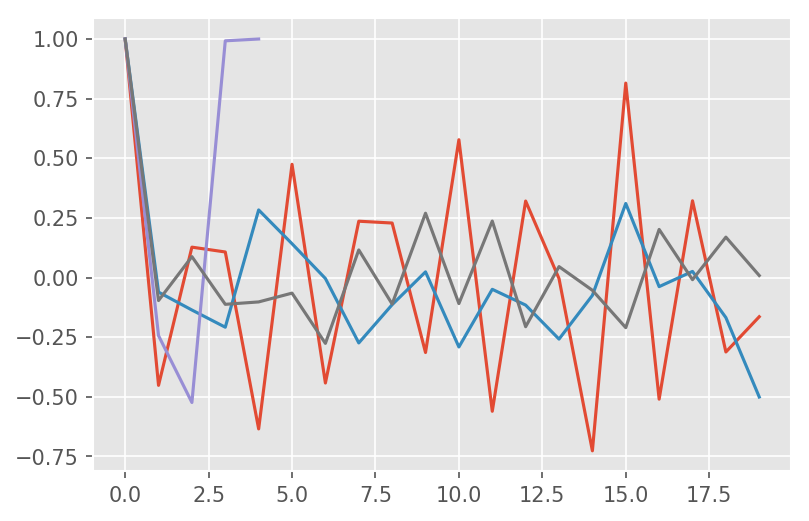

In [45]:

sqlTxt = '''
select strokes_gained_baseline, strokes_gained_category 
  from strokes 
  where player_id = 34046 
    and year = 2014 
    and strokes_gained_baseline is not null
  order by date limit 100;
  
'''
df = util.pd_from_sql(sqlTxt)
off_tee = df[df['strokes_gained_category']=='Off the Tee']['strokes_gained_baseline']
approach = df[df['strokes_gained_category']=='Approach to the Green']['strokes_gained_baseline']
around = df[df['strokes_gained_category']=='Around the Green']['strokes_gained_baseline']
putting = df[df['strokes_gained_category']=='Putting']['strokes_gained_baseline']
r = range(0, 20)
plt.plot(r, [off_tee.autocorr(i) for i in r])
# plt.plot(m_r(off_tee), off_tee)
plt.plot(r, [approach.autocorr(i) for i in r])
plt.plot(r, [around.autocorr(i) for i in r])
plt.plot(r, [putting.autocorr(i) for i in r])
off_tee.describe()

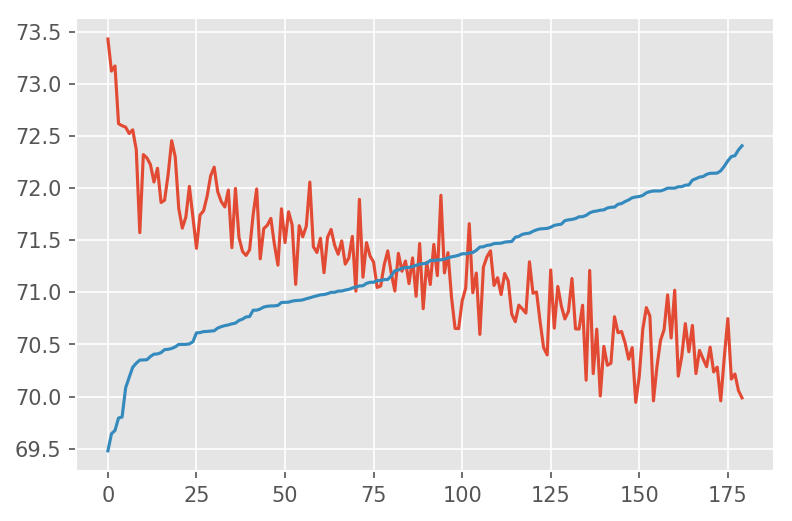

In [47]:

sqlTxt = '''
select avg_score, avg_sg_tee + avg_sg_approach + avg_sg_around + avg_sg_putting as avg_sg from stats_view limit 180
'''
df = util.pd_from_sql(sqlTxt)
# foo = plt.errorbar(range(0, len (df)), df['avg_score'], df['std_score'], linestyle='None', marker='^')
plt.plot(range(0, len (df)), df['avg_sg'] + 71)
plt.plot(range(0, len (df)), df['avg_score'])